## Preparations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')
# --- CONFIGURATION (Adjust Paths as needed) ---

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.append(str(SRC))

try:
    from core.sounding_generator import (generate_sounding,
                                         read_input_sounding, 
                                         write_input_sounding,
                                         calculate_diagnostics)
    from core.plot_utils import prepare_skewt_hodograph, plot_sounding,plot_sounding_full
except ImportError:
    print("ERROR: Could not import 'sounding_generator'.")
    print("Make sure 'sounding_generator.py' exists in the 'src/core/' directory.")
    sys.exit(1)
# --- Configuration ---
CONFIG_FILE = f'{REPO_ROOT}/configs/experiment_config.yaml'


# Load configuration
with open(CONFIG_FILE, 'r') as f:
    config = yaml.safe_load(f)

problem_definition = config['SOBOL']['PROBLEM_DEFINITION']

# --- 1. Establish a Baseline Sounding (Midpoint of all parameters) ---
print("\n1. Establishing Baseline Sounding...")
baseline_params = {}
for param_name, param_range in problem_definition.items():
    min_val, max_val = param_range
    baseline_params[param_name] = (min_val + max_val) / 2.0

print("Baseline Parameters:", baseline_params)
base_sounding = config['PATHS']['BASE_SOUNDING_TEMPLATE']
base_sounding_path = f'{REPO_ROOT}/{base_sounding}'
baseline_sounding = generate_sounding(baseline_params,base_sounding_path)
base_sounding = read_input_sounding(base_sounding_path)
print("Baseline sounding generated.")



1. Establishing Baseline Sounding...
Baseline Parameters: {'low_level_rh': 87.5, 'mid_level_rh': 55.0, 'upper_level_rh': 25.0, 'surface_theta': 301.0, 'z_ml_top': 1050.0, 'z_trop_top': 12000.0, 'theta_lapse': 3.5, 'shear_depth': 7500.0, 'shear_rate': 0.00166665, 'shear_curvature': 0.5}
Baseline sounding generated.


In [2]:
def vary_sounding(param_to_vary,base_sounding_path):
    
    num_test_values = 5
    test_fractions = np.linspace(0, 1, num_test_values)
    
    #print(f"\n--- Analyzing '{param_to_vary}' ---")
    param_range = problem_definition[param_to_vary]
    min_val, max_val = param_range
    
    varied_soundings = []
    param_values_used = []

    for frac in test_fractions:
        current_param_value = min_val + (max_val - min_val) * frac
        
        # Create a copy of baseline params
        test_params = baseline_params.copy()
        test_params[param_to_vary] = current_param_value
        
        #print(f"  Testing '{param_to_vary}' = {current_param_value:.2f}")
        varied_soundings.append(generate_sounding(test_params,base_sounding_path))
        param_values_used.append(current_param_value)

    return varied_soundings, param_values_used

# Variation in Humidity Profiles Parameters

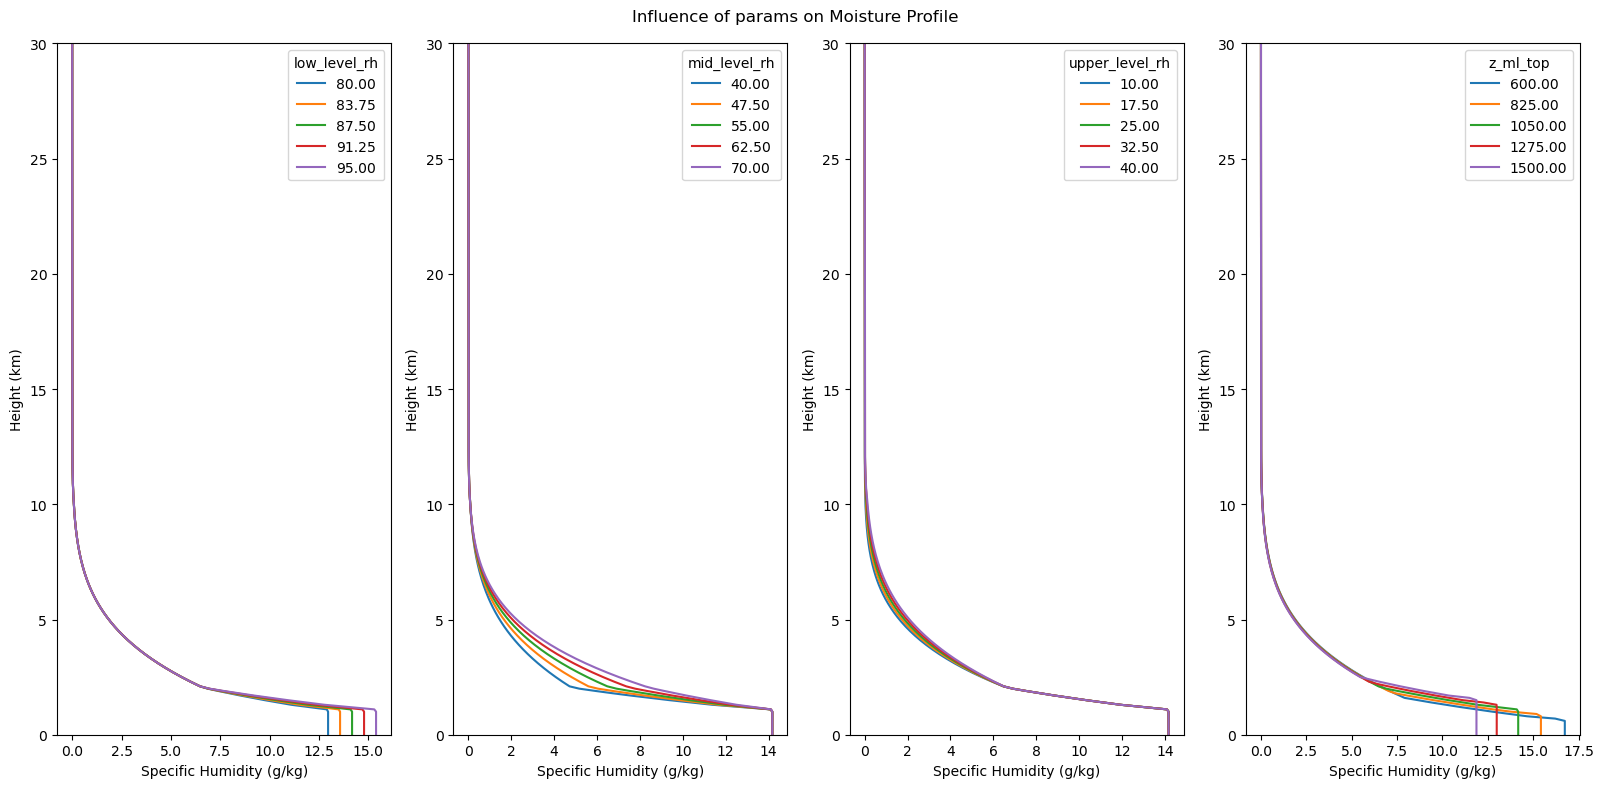

In [3]:
params_to_plot = ['low_level_rh', 'mid_level_rh', 'upper_level_rh', 'z_ml_top']
fig, axs = plt.subplots(1,4,figsize=(16, 8))
for j, param_to_vary in enumerate(params_to_plot):
    ax = axs[j]
    varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
    for i, snd in  enumerate(varied_soundings):
        ax.plot(snd['qv'], snd['height'] / 1000, 
                label=f"{param_values_used[i]:.2f}")        
    #ax.plot(base_sounding['qv'],base_sounding['height']/1000,'k--',label='Baseline') # default imput sounding from wrf}
    ax.legend(title=param_to_vary, loc='upper right')
    ax.set_xlabel('Specific Humidity (g/kg)')
    ax.set_ylabel('Height (km)')
    ax.set_ylim(0,30)
fig.suptitle(f'Influence of params on Moisture Profile')
plt.tight_layout()
plt.show()

# Variation in Temperature Profiles Parameters

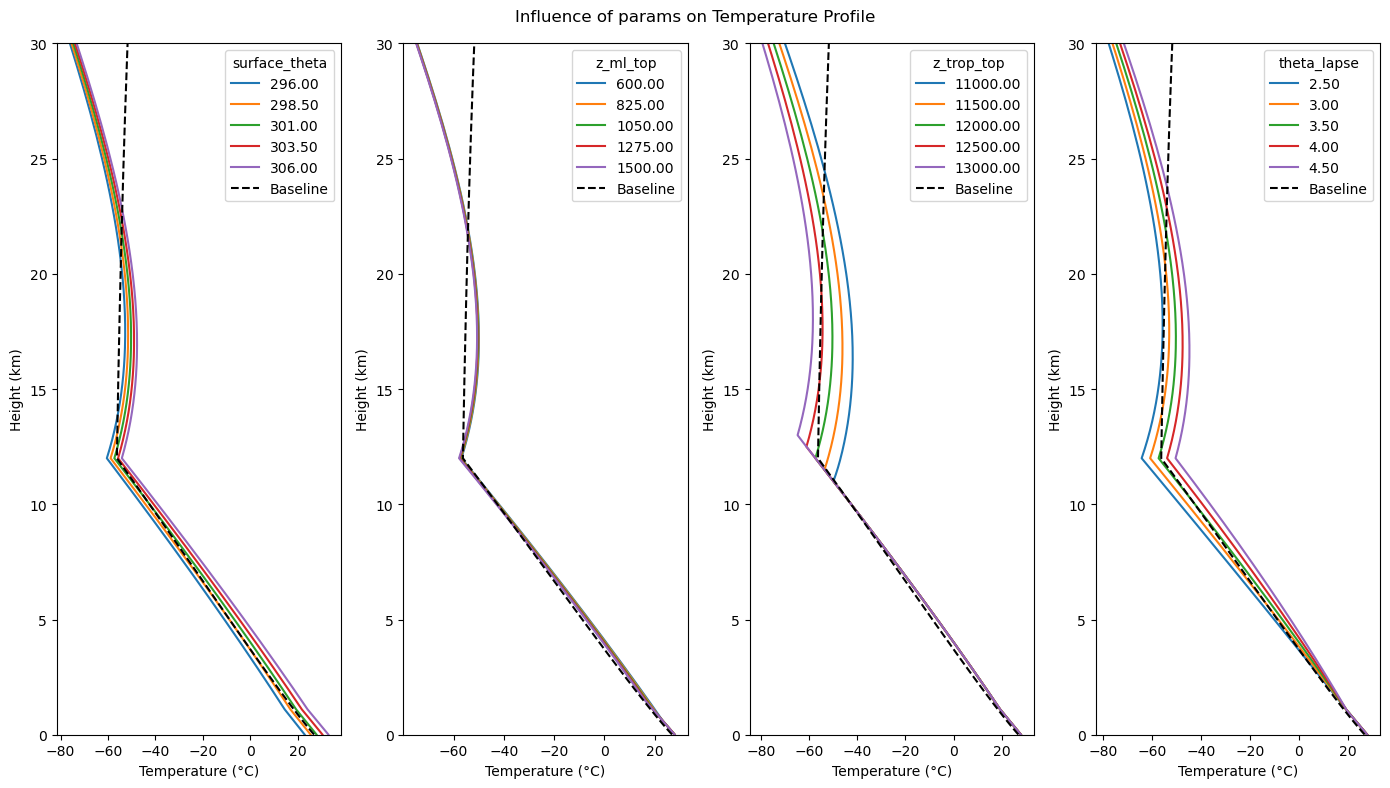

In [4]:
params_to_plot = ['surface_theta', 'z_ml_top', 'z_trop_top', 'theta_lapse']
fig, axs = plt.subplots(1,4,figsize=(14, 8))
for j, param_to_vary in enumerate(params_to_plot):
    # Create a small Skew-T for each parameter
    ax = axs[j]
    varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
    for i, snd in  enumerate(varied_soundings):
        ax.plot(snd['t'] - 273.15, snd['height'] / 1000, 
                label=f"{param_values_used[i]:.2f}")        
    ax.plot(base_sounding['t'] - 273.15,base_sounding['height']/1000,'k--',label='Baseline') # default imput sounding from wrf}
    ax.legend(title=param_to_vary, loc='upper right')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Height (km)')
    ax.set_ylim(0,30)
fig.suptitle(f'Influence of params on Temperature Profile')
plt.tight_layout()
plt.show()

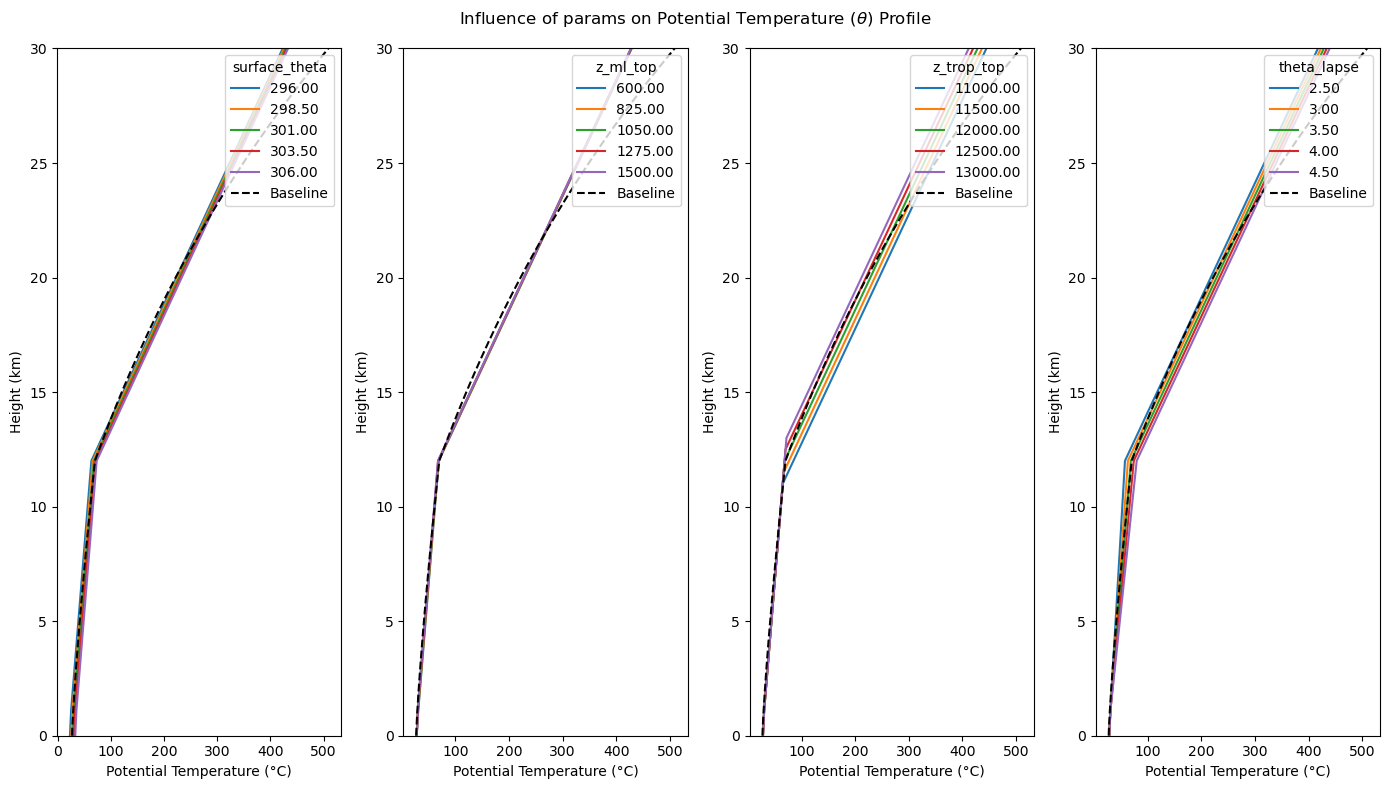

In [5]:
params_to_plot = ['surface_theta', 'z_ml_top', 'z_trop_top', 'theta_lapse']
fig, axs = plt.subplots(1,4,figsize=(14, 8))
for j, param_to_vary in enumerate(params_to_plot):
    # Create a small Skew-T for each parameter
    ax = axs[j]
    varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
    for i, snd in  enumerate(varied_soundings):
        ax.plot(snd['theta'] - 273.15, snd['height'] / 1000, 
                label=f"{param_values_used[i]:.2f}")        
    ax.plot(base_sounding['theta'] - 273.15,base_sounding['height']/1000,'k--',label='Baseline') # default imput sounding from wrf}
    ax.legend(title=param_to_vary, loc='upper right')
    ax.set_xlabel(r'Potential Temperature (°C)')
    ax.set_ylabel('Height (km)')
    ax.set_ylim(0,30)
fig.suptitle(rf'Influence of params on Potential Temperature $(\theta)$ Profile')
plt.tight_layout()
plt.show()

# Varitation in Wind Profiles Parameters

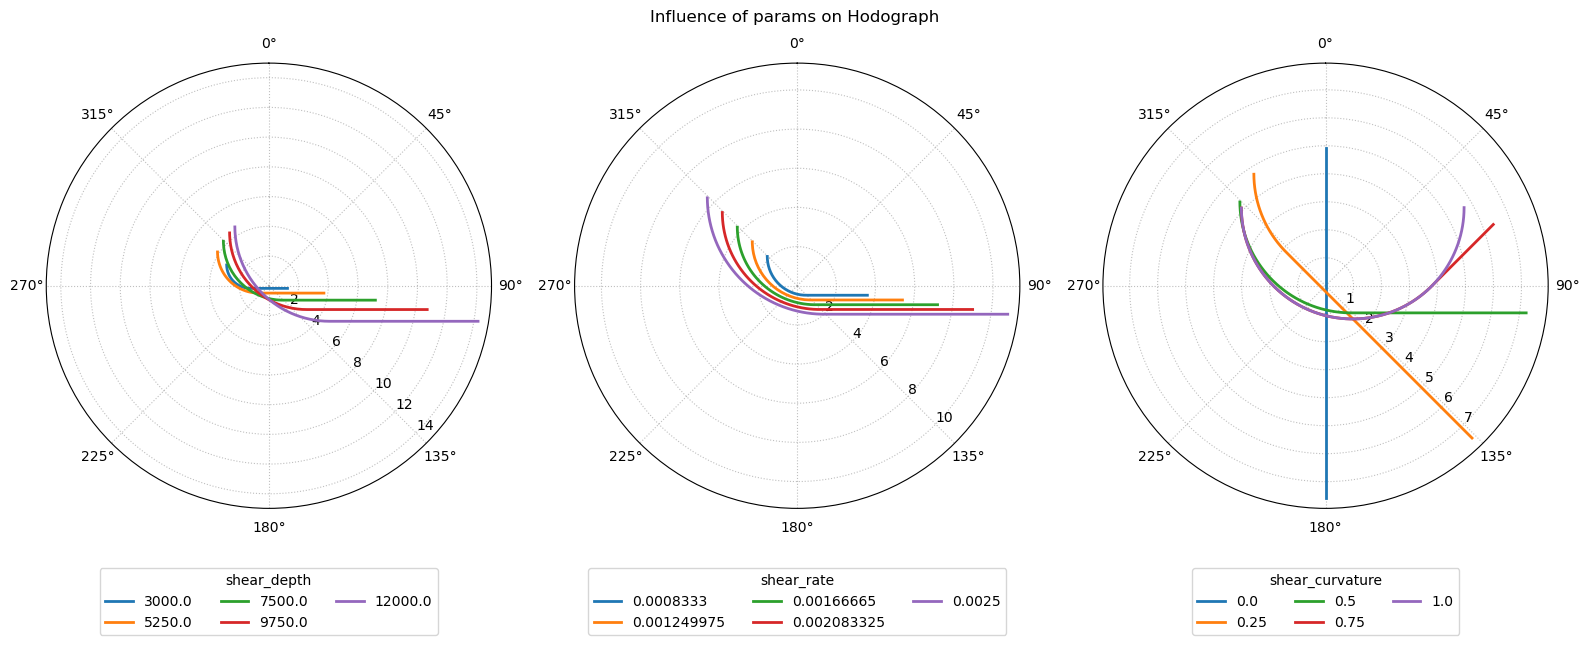

In [6]:
fig, axs = plt.subplots(1,3,figsize=(16, 6), subplot_kw={'projection': 'polar'})
params_to_plot = ['shear_depth', 'shear_rate', 'shear_curvature']

for j, param_to_vary in enumerate(params_to_plot):
    # Create a small Skew-T for each parameter
    ax = axs[j]
    varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
    for i, snd in enumerate(varied_soundings):
        speed = np.sqrt(snd['u']**2 + snd['v']**2)
        angle = np.arctan2(snd['u'], snd['v']) # Angle for plotting in polar (from +V axis)
        
        # Filter for heights below 15 km for better focus
        mask = snd['height'] <= 15000
        ax.plot(angle[mask], speed[mask], linewidth=2, 
                label=f"{param_values_used[i]}")
    # 'rows' is not a valid argument for matplotlib.legend; use 'ncol' to arrange entries into columns
    ax.legend(title=f'{param_to_vary}', loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.3))
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1) # Clockwise
    ax.set_rlabel_position(135) # radial labels (metres)
    ax.grid(True, which='both', linestyle=':', color='gray', alpha=0.5)
fig.suptitle(rf'Influence of params on Hodograph')
plt.tight_layout()
plt.show()

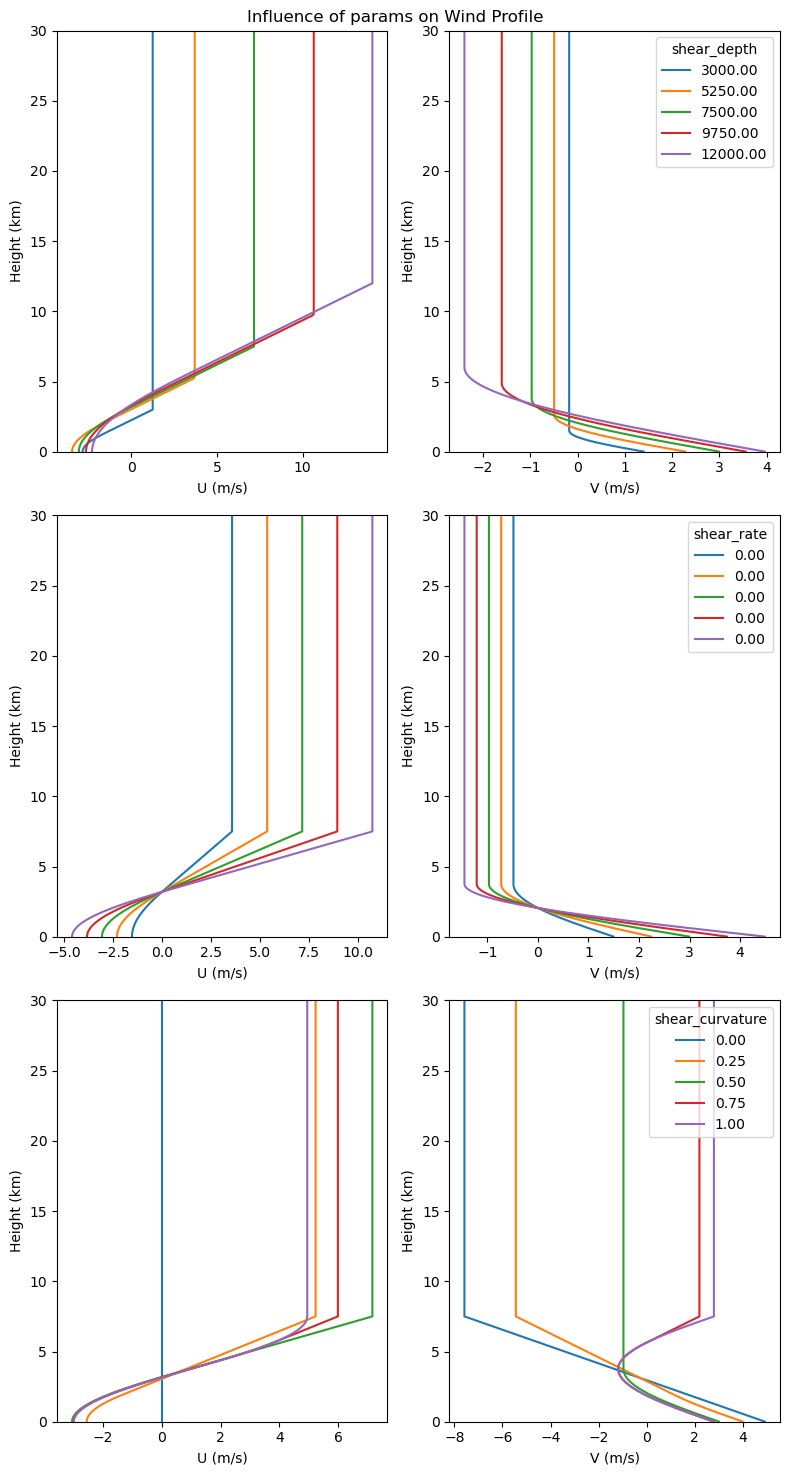

In [7]:
fig, ax = plt.subplots(3,2,figsize=(8, 15))

param_to_vary = 'shear_depth'
varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
for i, snd in enumerate(varied_soundings):
    ax[0,0].plot(snd['u'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[0,1].plot(snd['v'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[0,1].legend(title=param_to_vary, loc='upper right')
    ax[0,0].set_xlabel('U (m/s)')
    ax[0,1].set_xlabel('V (m/s)')

param_to_vary = 'shear_rate'
varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
for i, snd in enumerate(varied_soundings):
    ax[1,0].plot(snd['u'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[1,1].plot(snd['v'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[1,1].legend(title=param_to_vary, loc='upper right')
    ax[1,0].set_xlabel('U (m/s)')
    ax[1,1].set_xlabel('V (m/s)')

param_to_vary = 'shear_curvature'
varied_soundings, param_values_used = vary_sounding(param_to_vary,base_sounding_path)
for i, snd in enumerate(varied_soundings):
    ax[2,0].plot(snd['u'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[2,1].plot(snd['v'], snd['height'] / 1000, label=f"{param_values_used[i]:.2f}")
    ax[2,1].legend(title=param_to_vary, loc='upper right')
    ax[2,0].set_xlabel('U (m/s)')
    ax[2,1].set_xlabel('V (m/s)')

for axs in ax.flatten():
    axs.set_ylabel('Height (km)')
    axs.set_ylim(0,30)
plt.suptitle(f'Influence of params on Wind Profile')
plt.tight_layout()
plt.show()